# Tests JSA calculation class

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import savemat
from matplotlib.ticker import MaxNLocator

from topdc_calc import topdc_calc

#### Import the dispersion parameters

In [ ]:
#Dispersion import 

dispdata=np.load('disp_data.npy',allow_pickle=True).item()
omf=dispdata['omf']
triplet_neff=dispdata['triplet_neff']
omp=dispdata['omp']
pump_neff=dispdata['pump_neff']
wp_cutoff=9.8  #Pump mode cutoff frequency in 10^14 rad/s

test=topdc_calc(omf,triplet_neff,omp,pump_neff,wp_cutoff)

In [3]:
# Declaration of variables

c0=3 # Velocity of light in vacuum in um/(1e-14 s)
L=300000 # Waveguide length in um ->10000 um=1 cm

wf0=test.w_pm(13)   # Triplet phase-matching frequency in 10^14 rad/s (The input parameter 13  is the initial guess for the triplet central frequency--> You can check this by plotting the dispersion of the pump and triplet modes) 
wp0=3*wf0   # Pump phase-matching frequency in 10^14 rad/s 

In [4]:
print('Triplet central frequency: '+str(wf0)+' [x10^14 rad/s]')
print('Triplet central wavelength: '+str(2*np.pi*c0/wf0)+' um')
print('Pump central frequency: '+str(wp0)+' [x10^14 rad/s]')
print('Pump central wavelength: '+str(2*np.pi*c0/wp0)+' um')

Triplet central frequency: 13.696149605647763 [x10^14 rad/s]
Triplet central wavelength: 1.3762667949951373 um
Pump central frequency: 41.08844881694329 [x10^14 rad/s]
Pump central wavelength: 0.45875559833171237 um


In [5]:
#Evaluation of the JSA

# Spectral resolution
sigmap=test.pm_bw(L,13) #Half-width (at 1/e-pump intensity point) matching approximately the width of the phase-matching function, measured in terms of the sinc's main lobe width
delw=sigmap/60 # The spectral resolution is defined such that a minimum of 60 discrete points are sampled within each frequency vector over the bandwidth of the phase-matching function, regardless of the specific width of the evaluation function.

#Spectral window
domg=8*sigmap # We set the half-width of the frequency window wide enough to sample correctly both the jsa and reduced density matrix
omf1=np.arange(wf0-domg,wf0+domg,delw) # Frequency evaluation vector centered at the photon triplet phase-matching frequency with units 10^14 rad/s
print(omf1.size) # Note: Always check the frequency vector size, because later we are going to build a 3D grid with it, which greatly affects the memory usage. 

960


We are going to filter outside the frequencies $[12.5,14.5]\times~10^{14}$ rad/s.

In [6]:
wlow=12.5 # Filter lower limit
whigh=14.5  # Filter higher limit

jnpts=50
sigma_vec=np.linspace(1e-24,10*sigmap,jnpts)

In [7]:
purevec=np.zeros_like(sigma_vec)
for i,sig in enumerate(sigma_vec):
    jsa_data=test.rho_filter(omf1[:,None,None],omf1[None,:,None],omf1[None,None,:],L,wp0,sig,wlow,whigh)  # Evaluation of the jsa calculation function
    purevec[i]=jsa_data.purity
    print(i,purevec[i])
    del jsa_data

/home/gisell/triplet_purity/topdc_calc.py:1207: RuntimeWarning: invalid value encountered in scalar divide
  purity = np.sum(S) ** 2 / np.sum(S**2)


0 nan
1 3.2414854083441664
2 1.8783162294478664
3 1.5313404778263668
4 1.4370010295292504
5 1.4442422987865489
6 1.4985198596213047
7 1.5715805508518603
8 1.6478628226886578
9 1.719649212974988
10 1.7838387184347575
11 1.8397580473228723
12 1.8878585613794119
13 1.9290216976597852
14 1.964221068386684
15 1.9943741102992856
16 2.0202877860303943
17 2.042648030934809
18 2.062027781064502
19 2.078901529900417
20 2.093660939517838
21 2.1066292348300224
22 2.1180736183370783
23 2.128215618442317
24 2.1372395588713218
25 2.1452994238058474
26 2.152524397415603
27 2.1590233275808437
28 2.164888325004608
29 2.170197670804795
30 2.1750181719936355
31 2.1794070760403996
32 2.1834136327686267
33 2.187080373487336
34 2.190444162716555
35 2.1935370664073717
36 2.19638707154327
37 2.199018684922506
38 2.201453433343632
39 2.203710283018429
40 2.2058059925599025
41 2.207755411136921
42 2.2095717311953855
43 2.2112667033964564
44 2.2128508200219854
45 2.214333471971467
46 2.2157230835671764
47 2.21702

/tmp/ipykernel_3441632/311430261.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(prop={'size':10})


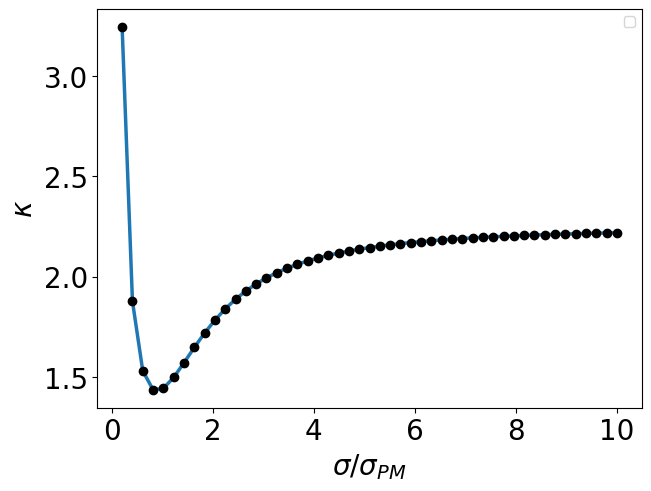

In [10]:
font={'size':20}
plt.rc('font',**font)

fig1, axs1 = plt.subplots(1, 1, sharex=True, sharey=True, constrained_layout=True)


plt.plot(sigma_vec/sigmap,purevec,linewidth=2.5)
plt.plot(sigma_vec/sigmap,purevec,'ko',linewidth=2.5)
plt.xlabel(r'$\sigma/\sigma_{PM}$') 
plt.ylabel(r"$\kappa$") 
# plt.xlim(omf[0]/jnp.sqrt(jnp.pi),omf[-1]/jnp.sqrt(jnp.pi))
  
plt.legend(prop={'size':10})

plt.savefig("Figures_export/Fiber_pump_bw_sweep.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Data export

In [ ]:
puredict={ 
    "tag":"Ideal case- Optimal pump bandwidth",
    "sigma":sigma_vec, 
    "purity":purevec
}
savemat("Data_export/Fiber_data_pump_bandwidth_sweep.mat",puredict)